---

# <div align="center"><font color='#003D66'>Human Action Recognition</font></div>
## <div align="center"><font color='#003D66'>Arvindh Bharadwaj Venkatesan</font></div>
---


## Introduction

The objective of this project is to develop a Human Action Recognition (HAR) system that can accurately classify actions and identify whether multiple people are present in images. This involves using a pre-trained Xception model, implementing data preprocessing and augmentation techniques, and applying a suitable evaluation framework to optimize and validate the model's performance.


In [40]:
import tensorflow as tf

# Check if TensorFlow can access a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Importing Libraries

In [100]:
# Importing neccessary libraries
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import plotly.express as px
import random
import tensorflow_addons as tfa
from itertools import cycle
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import TensorBoard
from keras_tuner import HyperModel
import keras_tuner as kt

from keras_tuner.tuners import RandomSearch
#from keras_tuner.engine import objectives


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display


In [42]:
# Checking if GPU is present
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [43]:
!pip install tensorflow_datasets

In [88]:
m_histories = {}
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)


logdir

WindowsPath('C:/Users/arvin/AppData/Local/Temp/tmptal_j8z8/tensorboard_logs')

In [46]:
# Checking the tensorflow version

# print the tensorflow version
print("Tensorflow version is: ", tf.__version__)

# produce an error if version is not equal to 2
assert tf.__version__[0] == '2'

Tensorflow version is:  2.10.1


## Reading the train data and test data csv file

In [47]:


# Mention the directory where the data is present
path = ""


# Reading the Train and test dataset from the csv file
data_train=pd.read_csv(path + "train_data_2024.csv")
data_test=pd.read_csv(path + "future_data_2024.csv")

* Checking if the loading has been proper

## Goal Setting

For this task, the primary goal is to achieve approximately 75% to 80% accuracy, with similar performance across both classes. To achieve this:

- **Loss Function**: Using binary crossentropy and Categorical Crossentropy.
- **Main Metric**: Accuracy and Binary Accuracy.
- **Additional Metrics**: Monitor recall and precision and f1-sccore to ensure balanced performance across classes for the best model.

By focusing on these metrics, I aim to not only reach high accuracy but also to ensure that the model performs well across different categories, minimizing any biases in predictions.


In [48]:
data_train.head()

FileName              Class MoreThanOnePerson  \
0   Img_460.jpg    blowing_bubbles               YES   
1  Img_8152.jpg    blowing_bubbles               YES   
2  Img_9056.jpg            jumping               YES   
3  Img_3880.jpg     pushing_a_cart               YES   
4  Img_3168.jpg  writing_on_a_book                NO   

            HighLevelCategory  
0    Social_LeisureActivities  
1    Social_LeisureActivities  
2           Sports_Recreation  
3           OutdoorActivities  
4  Artistic_MusicalActivities

* The dataset has images labeled with actions, showing if more than one person is involved, and grouped into categories like social, sports, and artistic activities. This helps in recognizing and understanding human actions in different situations.

In [49]:
data_train.shape

(4500, 4)

In [50]:
print(data_test.head())
data_test.shape

       FileName
0  Img_1963.jpg
1  Img_7244.jpg
2  Img_6218.jpg
3  Img_7703.jpg
4  Img_6318.jpg


(3128, 1)

* As we can see the training dataset has 4500 rows with 4 columns (input = FileName, output = class,MoreThanOnePerson, HighLevelCategory) 
* The test dataset has 3128 images for which we need to predict the class and MoreThanOnePerson

* The code updates the 'FileName' column to include the directory path "Images/" before the filename, making the path to each image more complete and accessible for processing.

In [51]:
data_train['FileName'] = "Images/"+data_train['FileName']
data_train.head()

FileName              Class MoreThanOnePerson  \
0   Images/Img_460.jpg    blowing_bubbles               YES   
1  Images/Img_8152.jpg    blowing_bubbles               YES   
2  Images/Img_9056.jpg            jumping               YES   
3  Images/Img_3880.jpg     pushing_a_cart               YES   
4  Images/Img_3168.jpg  writing_on_a_book                NO   

            HighLevelCategory  
0    Social_LeisureActivities  
1    Social_LeisureActivities  
2           Sports_Recreation  
3           OutdoorActivities  
4  Artistic_MusicalActivities

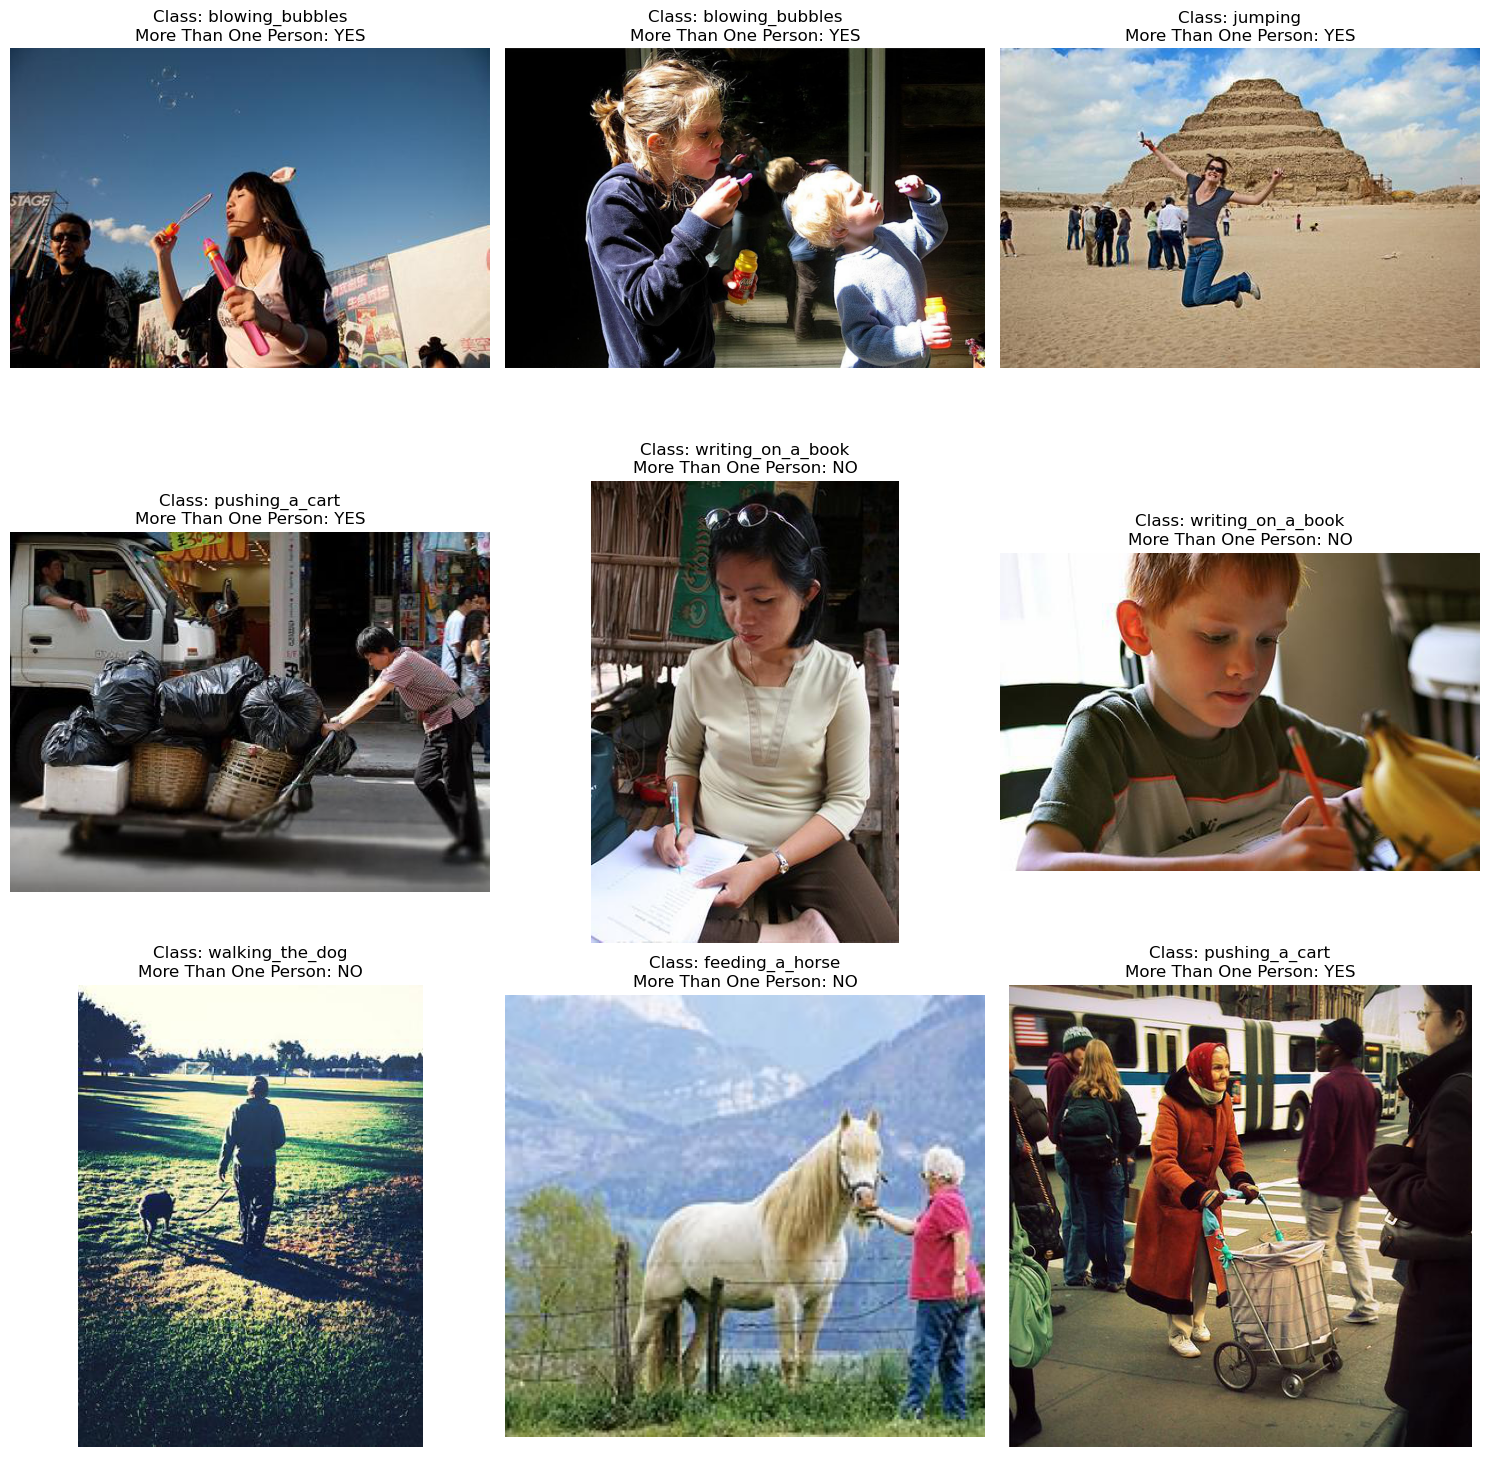

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Set the figure size
plt.figure(figsize=(15, 15))

# Loop through a subset of images and their labels
for i in range(9):  # Change range for more/less images
    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
    image_path = os.path.join(path, data_train['FileName'].iloc[i])
    image = mpimg.imread(image_path)
    
    # Display the image
    plt.imshow(image)
    
    # Display the title with class and MoreThanOnePerson info
    plt.title(f"Class: {data_train['Class'].iloc[i]}\n"
              f"More Than One Person: {data_train['MoreThanOnePerson'].iloc[i]}")
    
    # Turn off the axis
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


- I set up a 3x3 grid to show some images from my dataset to check whether its loaded properly. For each image, I added a title that tells the class and whether there’s more than one person in it. I removed the axes to make it look cleaner and easier to see.

## Exploratory Data Analysis

In [54]:
print(data_train.shape)
print(data_test.shape)

(4500, 4)
(3128, 1)


In [55]:
print(data_train.describe())
print(data_train.info())


                  FileName       Class MoreThanOnePerson  \
count                 4500        4500              4500   
unique                4500          40                 2   
top     Images/Img_460.jpg  applauding                NO   
freq                     1         222              2830   

               HighLevelCategory  
count                       4500  
unique                        10  
top     Social_LeisureActivities  
freq                         866  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   FileName           4500 non-null   object
 1   Class              4500 non-null   object
 2   MoreThanOnePerson  4500 non-null   object
 3   HighLevelCategory  4500 non-null   object
dtypes: object(4)
memory usage: 140.8+ KB
None


Here's a summary of my dataset:

- **Total Entries:** 4500
- **Unique FileNames:** 4500 (each image is unique)
- **Unique Classes:** 40 (different actions)
- **Unique Values in "MoreThanOnePerson":** 2 (YES or NO)
- **Unique High-Level Categories:** 10 (e.g., Social Leisure Activities, Sports Recreation)

All columns are non-null and contain object data types. The most frequent class is "applauding" with 222 occurrences, and the most common high-level category is "Social_LeisureActivities" with 866 occurrences.

In [56]:
data_train['Class'].value_counts()

applauding                      222
holding_an_umbrella             157
climbing                        155
riding_a_horse                  153
cooking                         153
playing_guitar                  152
walking_the_dog                 151
riding_a_bike                   144
jumping                         144
feeding_a_horse                 138
fishing                         136
blowing_bubbles                 132
drinking                        131
playing_violin                  130
phoning                         129
running                         124
fixing_a_car                    124
reading                         117
smoking                         115
writing_on_a_book               113
pushing_a_cart                  111
using_a_computer                107
fixing_a_bike                   107
cleaning_the_floor               92
watching_TV                      91
shooting_an_arrow                89
waving_hands                     88
pouring_liquid              

- The dataset shows a diverse range of action classes, with some actions (e.g., applauding) being much more frequent than others (e.g., washing dishes). This imbalance may impact model performance, with the model potentially being biased toward more frequent classes. We may need to address this imbalance, possibly through data augmentation or resampling techniques, to ensure that less frequent classes are adequately represented in the training process.

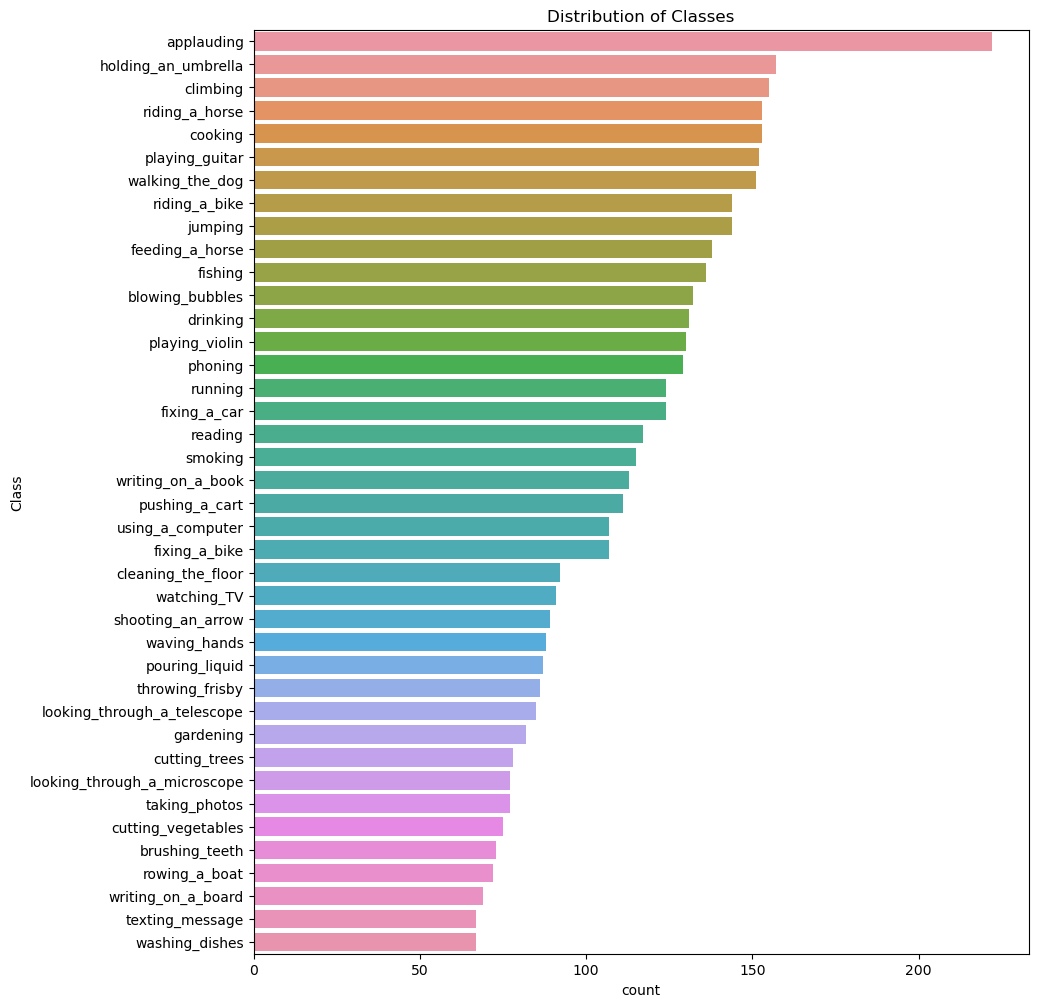

In [57]:
# Distribution of Classes
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 12))
sns.countplot(y='Class', data=data_train, order=data_train['Class'].value_counts().index)
plt.title('Distribution of Classes')
plt.show()



Here's the distribution of action classes in the dataset:

- **Most Frequent Actions:**
  - **Applauding:** 222 instances
  - **Holding an Umbrella:** 157 instances
  - **Climbing:** 155 instances
  - **Riding a Horse:** 153 instances
  - **Cooking:** 153 instances

- **Less Frequent Actions:**
  - **Washing Dishes:** 67 instances
  - **Texting Message:** 67 instances
  - **Writing on a Board:** 69 instances
  - **Rowing a Boat:** 72 instances

In [58]:


# Same above Class Distribution plot using plotly 
def plot_distribution_plotly(df, label):
    # Calculating the distribution
    class_distribution = df[label].value_counts().reset_index()
    class_distribution.columns = [label, 'Number of Images']
    
    # Creating a bar plot using Plotly
    fig = px.bar(class_distribution, x='Number of Images', y=label, 
                 title=f'Distribution of Images per {label}', 
                 labels={label: label, 'Number of Images': 'Number of Images'},
                 color='Number of Images',
                 text='Number of Images')
    
    # Updating layout
    fig.update_layout(yaxis_title=label, xaxis_title='Number of Images', 
                      xaxis=dict(tickangle=-45), 
                      yaxis=dict(autorange='reversed'))
    
    # Show plot
    fig.show()

# calling the function
plot_distribution_plotly(data_train, 'Class')


In [59]:
# Use this for distribution plot for morethanoneperson column
plot_distribution_plotly(data_train,'MoreThanOnePerson')

- From the distribution plot of the `MoreThanOnePerson` column, I see that there are 2830 instances where "NO" is marked, and 1670 instances where "YES" is marked. This means that our dataset has more images of single-person scenarios compared to multiple-person scenarios. This imbalance could affect the model's performance, so I might need to either balance the dataset or adjust the model to handle this difference better.


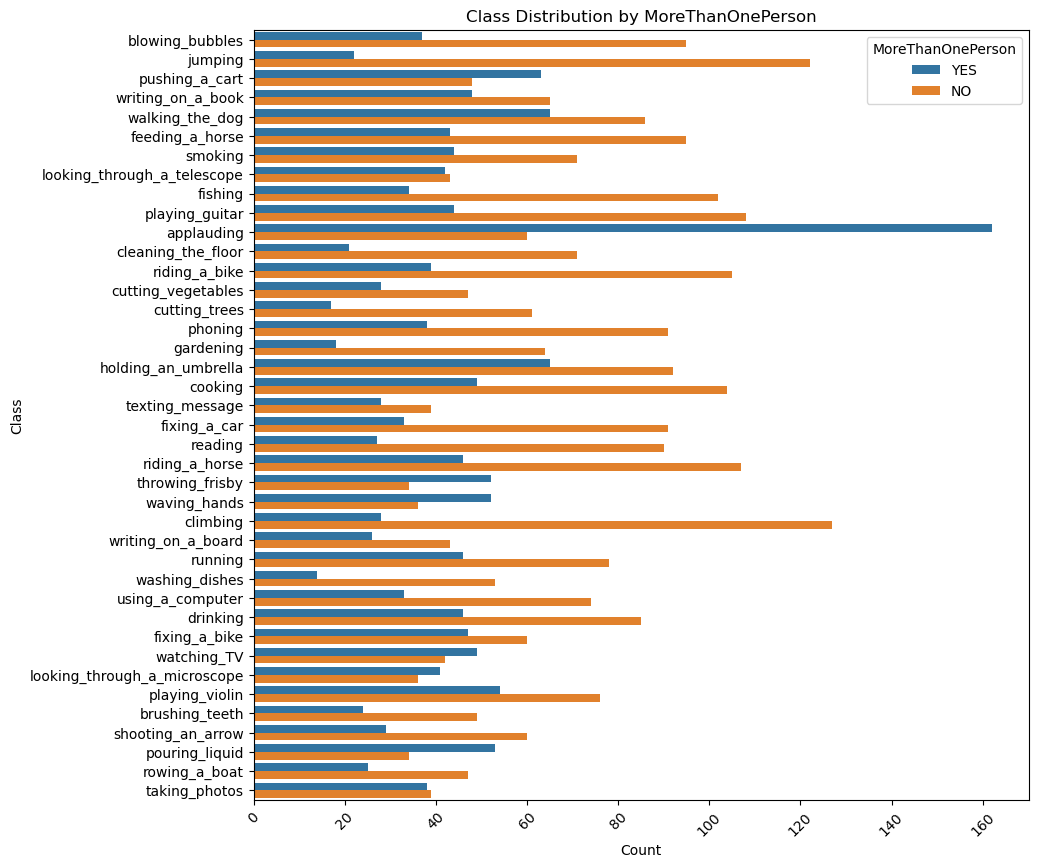

In [60]:


plt.figure(figsize=(10, 10))  # Increase the figure size for better readability
sns.countplot(y='Class', hue='MoreThanOnePerson', data=data_train)  # Switch x to y for horizontal bars
plt.title('Class Distribution by MoreThanOnePerson')
plt.xlabel('Count')  # Change the label of the x-axis
plt.ylabel('Class')  # Change the label of the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels if needed (for the count axis)
plt.show()



In [61]:
missing_values = data_train.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 FileName             0
Class                0
MoreThanOnePerson    0
HighLevelCategory    0
dtype: int64


* There are no missing values present in the training dataset

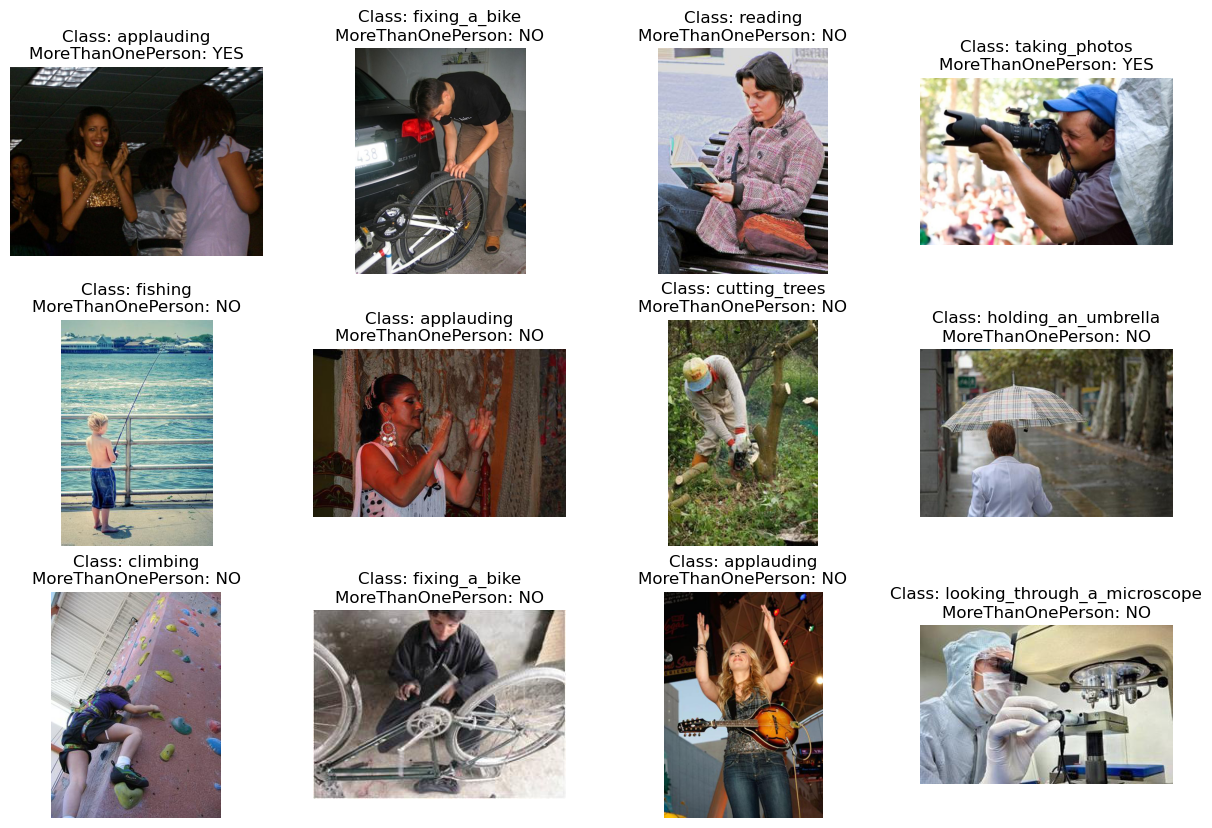

In [62]:

plt.figure(figsize=(15, 10))
for i in range(12):
    index = random.randint(0, len(data_train)-1)
    image_path = path + data_train['FileName'][index]
    image = mpimg.imread(image_path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {data_train['Class'][index]}\nMoreThanOnePerson: {data_train['MoreThanOnePerson'][index]}")
    plt.axis('off')
plt.show()


- The dataset contains a mix of images from both indoor and outdoor environments. For instance, some activities such as "cooking" and "cleaning_the_floor" are typically performed indoors, while activities like "fishing" and "running" are usually outdoor.

**Inference:**
- The diversity in the dataset, with images from both indoor and outdoor settings, ensures that the model can learn to recognize human actions in various environments. However, this variety also means that the model needs to generalize well across different contexts. The balance between indoor and outdoor images should be considered to `avoid biases` towards one setting, which could affect the model’s performance in real-world applications.


### Splitting Dataset into Train and Validation set

- I split the dataset into training, validation. Divided the data into training and validation sets, with 30% allocated for validation. The random state is set to 42 to ensure reproducibility of the splits.


In [63]:
train_data, val_data = train_test_split(data_train, test_size= 0.3, shuffle = True, random_state = 42)


In [64]:
# Checking if the data is splitted properly

print('Train Dataset size: ',train_data.shape)
print('Validation Dataset size: ',val_data.shape)


Train Dataset size:  (3150, 4)
Validation Dataset size:  (1350, 4)


- I converted image paths and labels into `TensorFlow tensors` to efficiently work with TensorFlow's data pipeline.
- Creating and adapting lookup layers for `one-hot encoding` is crucial for converting categorical labels into a format that the model can understand and learn from. 
- This transformation ensures that the labels are correctly represented as numerical vectors during training. Determining the number of unique classes helps in setting up the model's output layer to match the exact number of categories, ensuring accurate classification.


In [65]:
# Extracting paths and labels
train_image_paths = train_data['FileName'].values
train_action_labels = train_data['Class'].values
train_person_labels = train_data['MoreThanOnePerson'].values
val_image_paths = val_data['FileName'].values
val_action_labels = val_data['Class'].values
val_person_labels = val_data['MoreThanOnePerson'].values

# Convert to TensorFlow tensors
train_image_paths_tf = tf.constant(train_image_paths)
train_action_labels_tf = tf.constant(train_action_labels)
train_person_labels_tf = tf.constant(train_person_labels)
val_image_paths_tf = tf.constant(val_image_paths)
val_action_labels_tf = tf.constant(val_action_labels)
val_person_labels_tf = tf.constant(val_person_labels)


# Create lookup layers for action and person labels
action_tokenizer = tf.keras.layers.StringLookup(output_mode='one_hot', num_oov_indices=0)
person_tokenizer = tf.keras.layers.StringLookup(output_mode='one_hot', num_oov_indices=0)

# Adapting the vocab for action and person labels
action_tokenizer.adapt(train_action_labels_tf)
person_tokenizer.adapt(train_person_labels_tf)


# One-hot encode action and person labels
train_action_labels_tf = action_tokenizer(train_action_labels_tf)
train_person_labels_tf = person_tokenizer(train_person_labels_tf)
val_action_labels_tf = action_tokenizer(val_action_labels_tf)
val_person_labels_tf = person_tokenizer(val_person_labels_tf)


# # Getting the number of classes

total_action_classes = action_tokenizer.vocabulary_size()
total_person_classes = person_tokenizer.vocabulary_size()




In [66]:
print(train_action_labels_tf)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(3150, 40), dtype=float32)


In [67]:
# Ensure training_set and validation_set are correctly structured
training_set = tf.data.Dataset.from_tensor_slices((train_image_paths_tf,  {'action_task_labels': train_action_labels_tf,'person_task_labels':train_person_labels_tf}))

validation_set = tf.data.Dataset.from_tensor_slices((val_image_paths_tf,  {'action_task_labels':val_action_labels_tf,'person_task_labels':val_person_labels_tf}))



* I created `training_set` and `validation_set` TensorFlow datasets from the extracted image paths and labels. This step is essential to structure the data for efficient processing during model training and evaluation. 
* By using `tf.data.Dataset.from_tensor_slices`, I ensure that the data is organized in a way that TensorFlow can easily work with, including handling both the image paths and their corresponding labels for both action and person tasks.


### Data Augmentation

In [71]:


# Defining augmentation transformations
transformations = [
    # I defined a list of image augmentation transformations, including random rotation, horizontal flipping, width and height shifts.
    tf.keras.layers.RandomRotation(factor=20/360),  # Rotation within a specified range
    tf.keras.layers.RandomFlip(mode="horizontal"),  # Horizontal flipping
    tf.keras.layers.RandomWidth(0.15),  # Width shifting by 15%
    tf.keras.layers.RandomHeight(0.15)  # Height shifting by 15%
]

# Function to apply the transformations to images
def apply_transformations(input_image):

    augmented_image = input_image
    for transform in transformations:
        augmented_image = transform(augmented_image)
    return augmented_image



 * These transformations help increase the diversity of training data, which can improve model robustness. The `apply_transformations` function applies these augmentations to each image. Before applying the transformations, the function normalizes the image to ensure all pixel values are between 0 and 1, as the augmentations expect this input range.


In [72]:

def load_and_preprocess_image(image_path,labels):
    '''
    1. The `load_and_preprocess_image` function reads an image from a file path, decodes it, and resizes it to 256x256 pixels.
    2. It then applies several data augmentation transformations to the image. 
    3. After augmentation, the image is resized or padded to 224x224 pixels to match the input size required by the model. 
    This function also handles the corresponding labels. 
    '''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = apply_transformations(image)
    image = tf.image.resize_with_crop_or_pad(image, 224, 224)
    #image = tf.keras.applications.xception.preprocess_input(image)
    return image,labels



In [73]:
# Apply the function to the training and validation dataset
training_set = training_set.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
validation_set = validation_set.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


* I applied the `load_and_preprocess_image` function to both the training and validation datasets. This operation ensures that each image in the datasets is read, decoded, resized, augmented, and prepared consistently. The `map` function is used with `num_parallel_calls=AUTOTUNE` to efficiently preprocess the images in parallel.


In [74]:
BATCH_SIZE = 8
SHUFFLE_BUFFER_SIZE = 100

training_set = (training_set.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE))

validation_set = ( validation_set.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE))

* I configured the training and validation datasets for efficient processing by shuffling the training data, batching both datasets, caching them for faster access, and prefetching to improve performance. The `SHUFFLE_BUFFER_SIZE` ensures randomization of the training data, while `BATCH_SIZE` sets the number of samples per batch. `AUTOTUNE` is used for optimal prefetching performance.


In [75]:
for images, labels in training_set.take(1):
    action_labels, person_labels = labels
    print(f"Type of action_labels: {type(action_labels)}")
    print(f"Type of person_labels: {type(person_labels)}")
    print(f"Action labels: {action_labels}")
    print(f"Person labels: {person_labels}")

Type of action_labels: <class 'str'>
Type of person_labels: <class 'str'>
Action labels: action_task_labels
Person labels: person_task_labels


* The `visualize_train_dataset` function displays a specified number of images and their associated labels from the training dataset. It retrieves a batch of images and labels, normalizes the images, and plots them in a grid. For each image, it shows the action and person labels, handling cases where labels are one-hot encoded. This visualization helps to ensure that the images and their corresponding labels are correctly aligned and allows for manual inspection of the data.


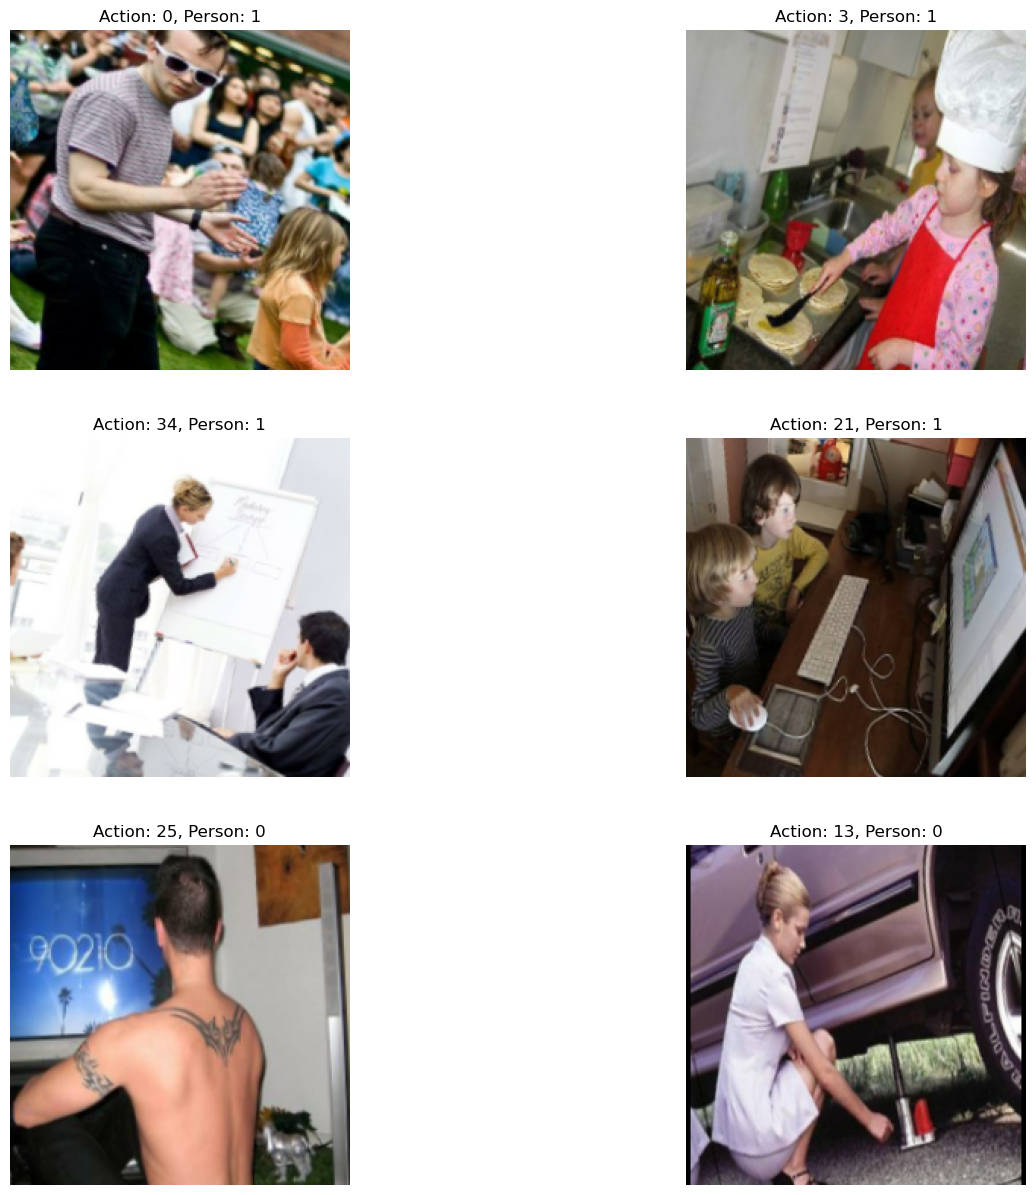

In [81]:

def visualize_train_dataset(sample_count):
    """Visualizes a batch of images and their labels."""
    # Taking one batch from the training dataset
    visualization_data = training_set.take(1)
    
    # Setting up the plotting area
    plt.figure(figsize=(16, 5 * (sample_count // 2 + sample_count % 2)))
    
    # Looping through the dataset and plotting images
    for images, labels in visualization_data:
        # Extracting images and labels
        if isinstance(labels, dict):
            action_labels = labels.get('action_task_labels', None)
            person_labels = labels.get('person_task_labels', None)
        else:
            # If labels are not in dict format, adjusting accordingly
            action_labels, person_labels = labels
        
        
        for j in range(min(sample_count, images.shape[0])):
            ax = plt.subplot((sample_count + 1) // 2, 2, j + 1)
            image = images[j]
            
            # Normalizing pixel values to [0, 1] range
            image_np = image.numpy() / 255.0
            
            # Displaying the image
            ax.imshow(image_np)
            
            # Extracting and displaying labels correctly
            action_label = action_labels[j].numpy() if hasattr(action_labels[j], 'numpy') else action_labels[j]
            person_label = person_labels[j].numpy() if hasattr(person_labels[j], 'numpy') else person_labels[j]
            
            # If labels are one-hot encoded, get the index of the maximum value
            if isinstance(action_label, np.ndarray):
                action_label = np.argmax(action_label)
            if isinstance(person_label, np.ndarray):
                person_label = np.argmax(person_label)
            
            # Setting the title using string labels or indices
            ax.set_title(f"Action: {action_label}, Person: {person_label}")
            ax.axis('off')
    
    # Show the plot
    plt.show()

# Example usage: Visualize 6 samples from the train dataset
visualize_train_dataset(6)


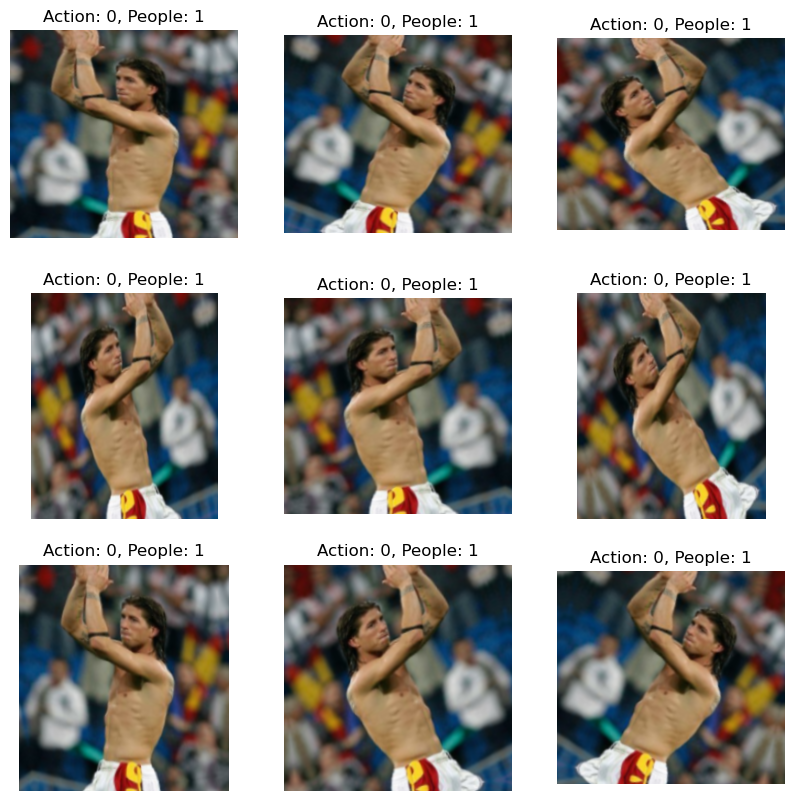

In [83]:

def visualize_augmented_images():
    # Taking one batch from the training dataset
    for images, labels in training_set.take(1):
        plt.figure(figsize=(10, 10))

        first_image = images[0]  # Take the first image from the batch
        
        # Get the action and person labels
        action_label = tf.argmax(labels['action_task_labels'][0]).numpy() if 'action_task_labels' in labels else 'Unknown'
        person_label = tf.argmax(labels['person_task_labels'][0]).numpy() if 'person_task_labels' in labels else 'Unknown'
        
        # Generate augmented images
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            augmented_image = apply_transformations(tf.expand_dims(first_image, 0))
            
            # Convert augmented image to numpy array and denormalize
            image_np = augmented_image[0].numpy()
            if image_np.max() > 1.0:  # If the image pixel values are in the range [0, 255]
                image_np = image_np / 255.0  # Normalize to [0, 1]
            
            plt.imshow(image_np)
            plt.title(f"Action: {action_label}, People: {person_label}")
            plt.axis("off")
        
        plt.show()

#  Visualize augmented images
visualize_augmented_images()


## Building Base Model

In [89]:
# The `STEPS_PER_EPOCH` variable defines the number of steps the model will go through in one epoch. 
# This ensures that each batch of images is processed during training. Adjust `BATCH_SIZE` if it's different from 8 to ensure /
# the correct number of steps per epoch.


# Calculate steps per epoch
STEPS_PER_EPOCH = len(train_image_paths_tf) // 8  # Adjust batch size here

#The callbacks function returns earlystopping and tensorboard
# 1.EarlyStopping: Monitors the validation loss and stops training if it doesn't improve for 20 epochs, preventing overfitting.

def get_callbacks(name):
    # Define TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Add any other callbacks if needed
    return [tensorboard_callback]



* The `compile_and_fit_Xception` function configures and trains an Xception model using the provided training and validation datasets. 
* It compiles the model with the Adam optimizer and categorical cross-entropy loss functions for both action and person tasks. It tracks accuracy and binary accuracy as metrics. 
* The model is then trained for a specified number of epochs with early stopping and TensorBoard callbacks. The function returns the trained model and its training history.


#### Why I choose this evaluation metrics?

#### Compile and Fit Xception Model

In the `compile_and_fit_Xception` function, I have selected specific loss functions and metrics for each type of output:

##### Loss Functions

- **Categorical Crossentropy**: 
  - **For action_task_labels**: This loss function is suitable for multi-class classification tasks, where we have 40 different classes. It measures how well the predicted probabilities match the actual labels and is effective for handling this multi-class scenario.
  - **For person_task_labels**: Although there are only two possible classes (yes/no), categorical crossentropy is used here as it can handle binary classification in a multi-class setting.

##### Metrics

- **Accuracy**:
  - **For action_task_labels**: This metric calculates the proportion of correct predictions across all classes. It provides a clear measure of the overall performance of the model on this multi-class classification task.
  
- **Binary Accuracy**:
  - **For person_task_labels**: This metric is used to evaluate the correct predictions for the binary classification task (presence/absence of multiple people). It helps in understanding how well the model distinguishes between the two classes.
  
##### Choosing the Adam Optimizer

I selected the Adam optimizer for the following reasons:

- **Adaptive Learning Rates**: Adam adjusts the learning rates for each parameter individually. This means it can adapt to the different needs of each weight in the model, which helps in faster and more stable convergence during training.
  
- **Momentum**: It incorporates momentum by using past gradients to smooth out the optimization process. This helps in navigating through areas of high curvature and avoiding oscillations, making the training process smoother.

- **Efficiency**: Adam is computationally efficient and requires little memory. It combines the advantages of two other popular optimizers (AdaGrad and RMSProp), making it suitable for a wide range of tasks and models.

Overall, Adam provides a good balance of speed and performance, making it a reliable choice for training deep learning models.



In [90]:
MAX_EPOCHS = 100

def compile_and_fit_Xception(model, training_set, validation_set, epochs=5, log_dir='logs'):

    
    # Compiling the model with updated loss functions and metrics
    model.compile(
         optimizer=tf.keras.optimizers.Adam(),
        loss={
            'action_task_labels' : tf.keras.losses.CategoricalCrossentropy(),
            'person_task_labels' : tf.keras.losses.CategoricalCrossentropy()
        },
        metrics= {
            'action_task_labels' : 'accuracy',
            'person_task_labels' : 'binary_accuracy',
        }
    )

        
  # Fit the model
    history = model.fit(
        training_set,
        epochs=epochs,
        validation_data=validation_set,
        callbacks=get_callbacks(log_dir),  # Ensure you have a `get_callbacks` function if used
        verbose=1
    )
    
    return model, history    
    


- The `base_model` function constructs a model using `Xception` as the base, with `pre-trained weights` and `excluding the top layers`. 
- It applies image scaling and passes the images through the Xception model. The output is processed through two separate branches: each branch includes global average pooling and dropout layers. 
- The model has two outputs: `one for action` classification with 40 classes and `one for person` classification with 2 classes.


### Justification for Choosing Xception Model

In selecting the Xception model for this task, we considered its robust performance and architecture, as detailed in the paper by Chollet (2017): [**Xception: Deep Learning with Depthwise Separable Convolutions**](https://arxiv.org/abs/1610.02357). The Xception model stands out due to its use of depthwise separable convolutions, which significantly improve performance over traditional convolutional layers.

#### Advantages of Xception:

- **Efficiency in Computation**:  
  Xception's depthwise separable convolutions reduce the number of parameters and computational complexity compared to standard convolutional layers. This is particularly advantageous when working with large datasets and complex models, allowing for faster training and inference.

- **Pre-trained Weights**:  
  The model comes with pre-trained weights from the ImageNet dataset, providing a strong foundation and enabling transfer learning. This allows us to leverage learned features from a large, diverse dataset, which can improve performance on our specific task of human action recognition.

- **Model Flexibility**:  
  Xception's architecture is well-suited for handling various image recognition tasks. By excluding the top classification layers and adding our custom classification layers, we adapt the model for multi-task learning with two outputs: action classification and person classification.

- **Strong Baseline**:  
  Research shows that Xception often outperforms other models like VGG and Inception in terms of accuracy and efficiency. Its architecture is designed to capture complex features in images, making it a strong candidate for recognizing various human actions in our dataset.
  
Additionally, a paper by Azmain Yakin Srizon, S. M. Mahedy Hasan, Md. Farukuzzaman Faruk, Abu Sayeed, and Md. Ali Hossain (2020) titled [*Human Activity Recognition Utilizing Ensemble of Transfer-Learned Attention Networks and a Low-Cost Convolutional Neural Architecture*](https://ieeexplore.ieee.org/document/8771481) demonstrates the effectiveness of Xception for human activity recognition. This study highlights Xception's ability to achieve high accuracy and efficiency in recognizing complex human activities, further supporting its suitability for our task.





In summary, Xception's advanced convolutional techniques, pre-trained weights, and flexibility make it a suitable choice for our human action recognition task. Its efficiency and strong baseline performance align with the needs of our project, providing both speed and accuracy benefits.


In [96]:
# True test1 xception

# Base model test 2


base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


def base_model(base_model):
    """
    ### Explanation of Layer Choices and Parameters:

    - **Base Model (`base_model_xception`)**:
      - **Pre-trained Weights**: We use the Xception model with pre-trained weights from ImageNet. This provides a solid foundation
          of learned features from a diverse dataset, which is beneficial for our human action recognition task. By excluding the  
          top (classification) layers, we retain the model's ability to extract high-level features while adding our custom layers 
          for specific classification tasks.

    - **Input Size (`input_shape=(224, 224, 3)`)**:
      - **Choice of Size**: The input size of 224x224 pixels is a common standard for many convolutional neural networks, including 
          Xception. This size strikes a balance between retaining sufficient detail in the images and keeping computational 
          requirements manageable. It ensures compatibility with the pre-trained weights of Xception, which were trained on this 
          input size.

    - **Scaling Layer (`Rescaling(scale=1 / 127.5, offset=-1)`)**:
      - **Purpose**: This layer rescales the pixel values to the range [-1, 1], which is consistent with the preprocessing used 
          during the training of the pre-trained Xception model. Proper scaling helps the model converge more effectively by 
          maintaining the consistency of input data preprocessing.


    - **Dense Layers**:
      - **Action Classification Output**: A Dense layer with 40 units and a softmax activation function is used to classify the 
          images into one of 40 action classes. The softmax activation provides probabilities for each class, allowing the model to 
          predict the most likely action.
      - **Person Classification Output**: Another Dense layer with 2 units and a softmax activation function is used for binary 
          classification (presence/absence of multiple people). This layer predicts the probability of each class (yes/no) for the 
          person classification task.

    - **Model Outputs**:
      - **Two Outputs**: The model is designed with two separate outputs: one for action classification and one for person 
          classification. This multi-task learning approach allows the model to simultaneously predict different aspects of the 
          images, making it versatile and effective for the given tasks.
    """
    
    base_model_xception.trainable = False
    inputs = tf.keras.Input(shape=(224, 224, 3))
    # Applying scaling
    scale_layer = layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)

    x = base_model_xception(x, training=False)

    
    # GlobalAveragePooling2D Layer: This layer reduces the spatial dimensions of the feature maps while retaining the essential features. It aggregates 
    # information across the entire feature map, providing a compact representation that can be used for classification.
    x1 = GlobalAveragePooling2D()(x)
    
    # **Dropout Rate**: A dropout rate of 0.4 is chosen to reduce overfitting by randomly dropping 40% of the neurons during 
    # training. This helps the model generalize better by preventing it from becoming too reliant on any particular feature 
    # or set of features.
    x1 = Dropout(0.4)(x1)

    x2 = GlobalAveragePooling2D()(x)
    x2 = Dropout(0.4)(x2)
    
    # Split the base model output into two separate paths

    action_class_output = Dense(40, activation='softmax', name='action_task_labels')(x1)
    person_class_output = Dense(2, activation='softmax', name='person_task_labels')(x2)
    outputs = {'action_task_labels' : action_class_output, 'person_task_labels' : person_class_output}

    # Define the model with two outputs
    model = Model(inputs=inputs, outputs = outputs)

    return model




In [97]:
EPOCHS = 25 # Setting the number of epochs for training

log_dir = 'logs' # Directory for TensorBoard logs
model_1 = base_model(base_model_xception) # Creating the model with Xception base


# Compiling and training the model with TensorBoard logging
model_1, history_1 = compile_and_fit_Xception(
    model_1,
    training_set,
    validation_set,
    epochs=EPOCHS,
    log_dir=log_dir
)
# model_1 = compile_and_fit_Xception(model_1)
model_1.fit(training_set, epochs = 5, validation_data= validation_set)



Epoch 1/25
394/394 [==============================] - 35s 70ms/step - loss: 2.5119 - action_task_labels_loss: 1.8667 - person_task_labels_loss: 0.6453 - action_task_labels_accuracy: 0.5206 - person_task_labels_binary_accuracy: 0.6473 - val_loss: 1.6942 - val_action_task_labels_loss: 1.1663 - val_person_task_labels_loss: 0.5280 - val_action_task_labels_accuracy: 0.6726 - val_person_task_labels_binary_accuracy: 0.7348
Epoch 2/25
394/394 [==============================] - 26s 65ms/step - loss: 1.5175 - action_task_labels_loss: 0.9323 - person_task_labels_loss: 0.5852 - action_task_labels_accuracy: 0.7263 - person_task_labels_binary_accuracy: 0.6990 - val_loss: 1.5996 - val_action_task_labels_loss: 1.0838 - val_person_task_labels_loss: 0.5158 - val_action_task_labels_accuracy: 0.6896 - val_person_task_labels_binary_accuracy: 0.7526
Epoch 3/25
394/394 [==============================] - 26s 65ms/step - loss: 1.2801 - action_task_labels_loss: 0.7088 - person_task_labels_loss: 0.5713 - action_

394/394 [==============================] - 26s 67ms/step - loss: 0.6468 - action_task_labels_loss: 0.1074 - person_task_labels_loss: 0.5394 - action_task_labels_accuracy: 0.9749 - person_task_labels_binary_accuracy: 0.7432 - val_loss: 1.9092 - val_action_task_labels_loss: 1.3753 - val_person_task_labels_loss: 0.5339 - val_action_task_labels_accuracy: 0.6867 - val_person_task_labels_binary_accuracy: 0.7415
Epoch 21/25
394/394 [==============================] - 26s 66ms/step - loss: 0.6338 - action_task_labels_loss: 0.1003 - person_task_labels_loss: 0.5335 - action_task_labels_accuracy: 0.9787 - person_task_labels_binary_accuracy: 0.7524 - val_loss: 1.9054 - val_action_task_labels_loss: 1.3709 - val_person_task_labels_loss: 0.5346 - val_action_task_labels_accuracy: 0.6867 - val_person_task_labels_binary_accuracy: 0.7407
Epoch 22/25
394/394 [==============================] - 26s 66ms/step - loss: 0.6234 - action_task_labels_loss: 0.0919 - person_task_labels_loss: 0.5315 - action_task_labe

### Plot Accuracy Function

I wrote the `plot_accuracy` function to visualize accuracy metrics over epochs for different models. It takes a dictionary of model histories, plots training and validation metrics, and displays them with customized y-axis limits and labels.

Here's an example of how I use it:

```python
history_dict = {'Model1': history_1}
plot_accuracy(history_dict, metric='accuracy', ylim=[0.0, 1.0])

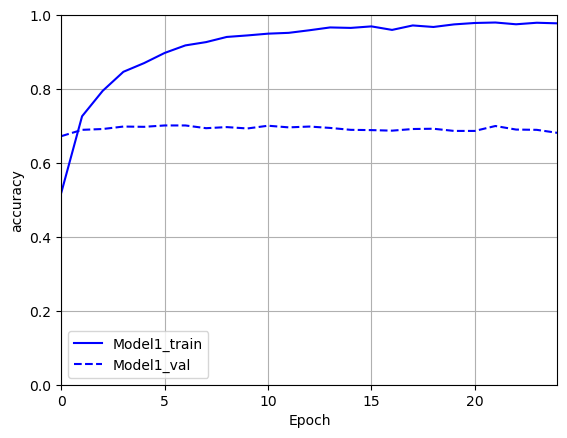

In [101]:
def plot_accuracy(history_dict, metric='accuracy', ylim=[0.0, 1.0]):
    cycol = cycle('bgrcmk')
    
    for model_name, history in history_dict.items():
        # Adjust the metric name to match what's in the history
        train_metric = 'action_task_labels_' + metric if 'action_task_labels_' + metric in history.history else metric
        val_metric = 'val_' + train_metric

        y_train = history.history.get(train_metric, [])
        y_val = history.history.get(val_metric, [])
        
        if not y_train:
            print(f"No data for metric: {metric} in history of {model_name}")
            continue
        
        epochs = np.arange(len(y_train))
        c = next(cycol)
        
        plt.plot(epochs, y_train, c + '-', label=model_name + '_train')
        plt.plot(epochs, y_val, c + '--', label=model_name + '_val')
    
    if len(y_train) > 0:
        plt.xlim([0, len(y_train) - 1])
    
    plt.ylim(ylim)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
history_dict = {'Model1': history_1}
plot_accuracy(history_dict, metric='accuracy', ylim=[0.0, 1.0])


## Improving Base Model

In [104]:
# Calculate steps per epoch
STEPS_PER_EPOCH = len(train_image_paths_tf) // 8  # Adjust BATCH_SIZE to 32 or your actual batch size

# # Learning rate schedule
# lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#     initial_learning_rate=0.001,

#     decay_steps=STEPS_PER_EPOCH * 1000,
#     decay_rate=1,
#     staircase=False
# )

### Explanation

- **`tf.keras.callbacks.LearningRateScheduler`**: Creates a callback to adjust the learning rate during training.
- **`lambda epoch: 1e-4 * 10 ** (epoch / 20)`**: Increases the learning rate exponentially each epoch, starting from `1e-4`.

### Why You Are Doing This

- **Dynamic Adjustment**: Helps in exploring the parameter space early on and can speed up convergence later in training.
- **Custom Strategy**: Allows for a tailored learning rate adjustment to fit specific training needs.


In [108]:

def create_lr_schedule():
    return tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-4 * 10 ** (epoch / 20)
    )

# Example of using the learning rate scheduler
lr_schedule = create_lr_schedule()

def compile_and_fit_Xception2(model, training_set, validation_set, epochs=10, log_dir='logs'):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss={
            'action_task_labels': tf.keras.losses.CategoricalCrossentropy(),
            'person_task_labels': tf.keras.losses.CategoricalCrossentropy()
        },
        metrics={
            'action_task_labels': ['accuracy'],
            'person_task_labels': ['binary_accuracy']
        }
    )
    
    history = model.fit(
        training_set,
        epochs=epochs,
        validation_data=validation_set,
        callbacks=[lr_schedule, tf.keras.callbacks.TensorBoard(log_dir=log_dir)],
        verbose=1
    )
    
    return model, history


**In the improved_model function:**

- **Batch Normalization:** Added after GlobalAveragePooling2D to stabilize and speed up training.
- **Higher Dropout Rate:** Increased to 0.45 to reduce overfitting more effectively.

In [109]:


def improved_model(base_model_xception):
    base_model_xception.trainable = False
    inputs = Input(shape=(224, 224, 3))
    
    # Apply scaling
    scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)

    # Apply base model
    x = base_model_xception(x, training=False)

    # Split the base model output into two separate paths
    x1 = GlobalAveragePooling2D()(x)
    x1 = BatchNormalization()(x1)  # Batch normalization
    x1 = Dropout(0.45)(x1)  # Dropout with a higher rate

    x2 = GlobalAveragePooling2D()(x)
    x2 = BatchNormalization()(x2)  # Batch normalization
    x2 = Dropout(0.45)(x2)  # Dropout with a higher rate
    
    action_class_output = Dense(40, activation='softmax', name='action_task_labels')(x1)
    person_class_output = Dense(2, activation='softmax', name='person_task_labels')(x2)
    
    outputs = {'action_task_labels': action_class_output, 'person_task_labels': person_class_output}
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model


Epoch 1/25
394/394 [==============================] - 26s 59ms/step - loss: 4.9737 - action_task_labels_loss: 3.8404 - person_task_labels_loss: 1.1333 - action_task_labels_accuracy: 0.1432 - person_task_labels_binary_accuracy: 0.5283 - val_loss: 2.9569 - val_action_task_labels_loss: 2.2176 - val_person_task_labels_loss: 0.7393 - val_action_task_labels_accuracy: 0.4096 - val_person_task_labels_binary_accuracy: 0.6185 - lr: 1.0000e-04
Epoch 2/25
394/394 [==============================] - 23s 59ms/step - loss: 3.2400 - action_task_labels_loss: 2.3398 - person_task_labels_loss: 0.9002 - action_task_labels_accuracy: 0.3911 - person_task_labels_binary_accuracy: 0.6073 - val_loss: 2.2206 - val_action_task_labels_loss: 1.5464 - val_person_task_labels_loss: 0.6741 - val_action_task_labels_accuracy: 0.5807 - val_person_task_labels_binary_accuracy: 0.6748 - lr: 1.1220e-04
Epoch 3/25
394/394 [==============================] - 23s 59ms/step - loss: 2.5393 - action_task_labels_loss: 1.7327 - person_

Epoch 20/25
394/394 [==============================] - 24s 60ms/step - loss: 0.8603 - action_task_labels_loss: 0.1961 - person_task_labels_loss: 0.6642 - action_task_labels_accuracy: 0.9311 - person_task_labels_binary_accuracy: 0.7127 - val_loss: 2.4520 - val_action_task_labels_loss: 1.8139 - val_person_task_labels_loss: 0.6381 - val_action_task_labels_accuracy: 0.6778 - val_person_task_labels_binary_accuracy: 0.6956 - lr: 8.9125e-04
Epoch 21/25
394/394 [==============================] - 24s 60ms/step - loss: 0.9174 - action_task_labels_loss: 0.2231 - person_task_labels_loss: 0.6943 - action_task_labels_accuracy: 0.9286 - person_task_labels_binary_accuracy: 0.7098 - val_loss: 2.5736 - val_action_task_labels_loss: 1.9488 - val_person_task_labels_loss: 0.6248 - val_action_task_labels_accuracy: 0.6763 - val_person_task_labels_binary_accuracy: 0.7215 - lr: 0.0010
Epoch 22/25
394/394 [==============================] - 24s 60ms/step - loss: 0.9555 - action_task_labels_loss: 0.2359 - person_t

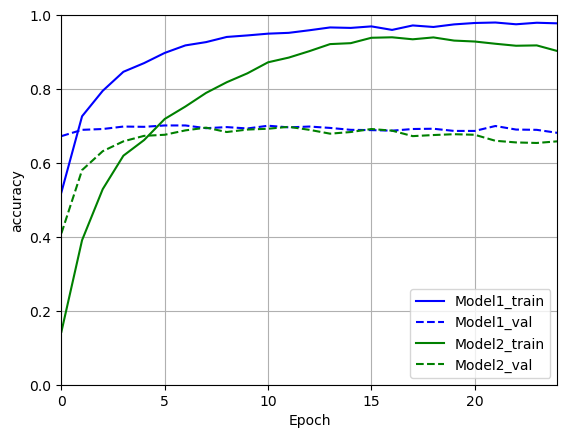

In [110]:
EPOCHS = 25
log_dir = 'logs'

# Create the model
model_2 = improved_model(base_model_xception)

# Compile and fit the model
model, history = compile_and_fit_Xception2(
    model_2,
    training_set,
    validation_set,
    epochs=EPOCHS,
    log_dir=log_dir
)

history_dict['Model2'] = history

# Plot training history
#history_dict = {'Model2': history}
plot_accuracy(history_dict, metric='accuracy', ylim=[0.0, 1.0])

In [111]:
!pip install keras_tuner


## Hyperparameter Tuning - Random search

### Purpose of the Code

This code performs **hyperparameter tuning** using **Random Search** to find the best learning rate for a multi-output model. It tunes the learning rate and trains the model on two tasks: `action_task_labels` and `person_task_labels`.

### Key Steps

1. **Model Definition**:
   - A model (`ModelHyperModel`) is created with two tasks.
   - Hyperparameter tuning is applied to the **learning rate** using `hp.Choice`.

2. **Random Search Setup**:
   - **Objective**: Maximize validation accuracy for `action_task_labels`.
   - **max_trials**: 5 different learning rates are tested.

3. **Running Hyperparameter Search**:
   - The tuner explores different learning rates, training for 10 epochs on each trial.

4. **Retrieve and Retrain the Best Model**:
   - After tuning, the best model is retrieved and retrained for 10 epochs.
   - The training history is saved for further analysis.

### Reason for using Random Search

- **Efficient exploration** of hyperparameter space.
- Automates the process of finding the **optimal learning rate**.
- Helps in optimizing **validation accuracy** without manual tuning.


In [112]:
### Trying random search and hyperparameter tuning


# Define the hypermodel
class ModelHyperModel(HyperModel):
    def build(self, hp):
        model = base_model(base_model_xception)
        
        # Hyperparameter tuning for learning rate
        optimizer = tf.keras.optimizers.Adam(hp.Choice('lr', [1e-4, 1e-3]))
        
        model.compile(
            optimizer=optimizer,
            loss={
                'action_task_labels': 'categorical_crossentropy',
                'person_task_labels': 'categorical_crossentropy'
            },
            metrics={
                'action_task_labels': 'accuracy',
                'person_task_labels': 'binary_accuracy'
            }
        )
        return model

# Initialize the hypermodel
hypermodel = ModelHyperModel()

# Set up the RandomSearch tuner
tuner = RandomSearch(
    hypermodel,
    objective=kt.Objective("val_action_task_labels_accuracy", direction="max"),
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# Run the hyperparameter search
tuner.search(training_set, epochs=10, validation_data=validation_set)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Optionally, retrain the best model
history_3 = best_model.fit(
    training_set,
    epochs=10,  # Use the number of epochs you prefer
    validation_data=validation_set
)
history_dict['Model3_random'] = history_3

# Add the history to your history dict
#history_dict = {'BestModel': history}


Reloading Tuner from my_dir\helloworld\tuner0.json
Epoch 1/10
394/394 [==============================] - 25s 59ms/step - loss: 1.2983 - action_task_labels_loss: 0.7228 - person_task_labels_loss: 0.5756 - action_task_labels_accuracy: 0.7784 - person_task_labels_binary_accuracy: 0.7162 - val_loss: 1.5806 - val_action_task_labels_loss: 1.0704 - val_person_task_labels_loss: 0.5102 - val_action_task_labels_accuracy: 0.6941 - val_person_task_labels_binary_accuracy: 0.7548
Epoch 2/10
394/394 [==============================] - 23s 58ms/step - loss: 1.1118 - action_task_labels_loss: 0.5542 - person_task_labels_loss: 0.5576 - action_task_labels_accuracy: 0.8333 - person_task_labels_binary_accuracy: 0.7324 - val_loss: 1.5919 - val_action_task_labels_loss: 1.0705 - val_person_task_labels_loss: 0.5215 - val_action_task_labels_accuracy: 0.7015 - val_person_task_labels_binary_accuracy: 0.7504
Epoch 3/10
394/394 [==============================] - 23s 59ms/step - loss: 1.0005 - action_task_labels_loss:

In [113]:
# Save the best model
best_model.save('best_model_random_2.h5')


In [116]:
print(history_dict)

{'Model1': <keras.callbacks.History object at 0x00000116F39D0D30>, 'Model2': <keras.callbacks.History object at 0x00000116F37F41C0>, 'Model3_random': <keras.callbacks.History object at 0x00000116E1909B20>}


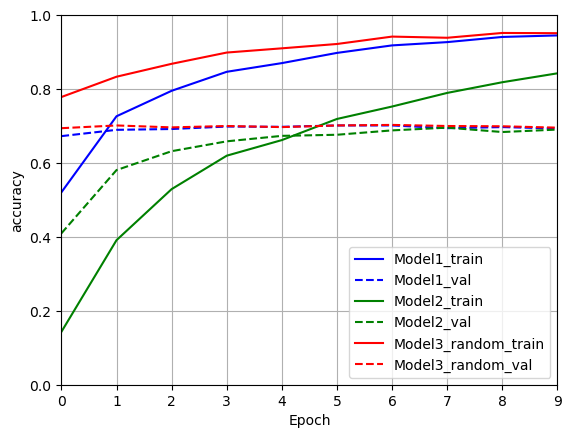

In [114]:
plot_accuracy(history_dict, metric='accuracy', ylim=[0.0, 1.0])

### Training and Validation Metrics Inference


### Model Performance Overview

As we can see from the graph above, we get a detailed overview of the model's performance over 10 epochs. Here's how to interpret the results:

1. **Loss Curves**:
   - **Training Loss**: Decreases consistently from 1.2983 to 0.7141, indicating that the model is learning and improving its performance on the training set.
   - **Validation Loss**: Shows an increasing trend from 1.5806 to 1.7316, suggesting potential overfitting. The widening gap between training and validation loss implies that the model may be fitting too closely to the training data and not generalizing well to unseen data.

2. **Accuracy Curves**:
   - **Action Task Labels Accuracy**:
     - **Training Accuracy**: Improves significantly from 77.84% to 95.11%, reflecting a strong learning trend on the training data.
     - **Validation Accuracy**: Remains relatively stable and lower, starting at 69.41% and ending at 69.56%. This indicates that the model's performance on the validation set is not improving as much, which suggests overfitting.

   - **Person Task Labels Binary Accuracy**:
     - **Training Accuracy**: Gradually increases from 71.62% to 74.44%, showing improvement in predicting person labels.
     - **Validation Accuracy**: Fluctuates, starting at 75.48% and decreasing to 73.78%. This variability on the validation set suggests inconsistency in the model's performance.


### Further Steps

The graphs suggest that the model is learning well on the training data but struggles to generalize to the validation set. Further steps can include:

- **Regularization**: Implementing techniques such as L2 regularization or dropout.
- **Model Adjustment**: Fine-tuning the model architecture or hyperparameters to better handle the validation data through random search.



### Adding L2 Regularizer along with Random Search

In [120]:

# Improved model with L2 regularization
def improved_model_l2(base_model_xception, l2_reg):
    base_model_xception.trainable = False
    inputs = Input(shape=(224, 224, 3))

    # Apply scaling
    scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)

    # Apply base model
    x = base_model_xception(x, training=False)

    # Apply L2 regularization
    l2_regularizer = regularizers.l2(l2_reg)

    # Split the base model output into two separate paths
    x1 = GlobalAveragePooling2D()(x)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.45)(x1)
    x1 = Dense(1024, activation='relu', kernel_regularizer=l2_regularizer)(x1)

    x2 = GlobalAveragePooling2D()(x)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.45)(x2)
    x2 = Dense(1024, activation='relu', kernel_regularizer=l2_regularizer)(x2)

    action_class_output = Dense(40, activation='softmax', name='action_task_labels')(x1)
    person_class_output = Dense(2, activation='softmax', name='person_task_labels')(x2)

    outputs = {'action_task_labels': action_class_output, 'person_task_labels': person_class_output}

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Define the hypermodel
class ModelHyperModel(HyperModel):
    def build(self, hp):
        # Build the base model
        
        # Apply L2 regularization
        l2_reg = hp.Choice('l2_reg', [1e-4, 1e-5])
        model_with_l2 = improved_model_l2(base_model_xception, l2_reg)
        
        # Hyperparameter tuning for learning rate
        optimizer = tf.keras.optimizers.Adam(hp.Choice('lr', [1e-4, 1e-3]))

        model_with_l2.compile(
            optimizer=optimizer,
            loss={
                'action_task_labels': 'categorical_crossentropy',
                'person_task_labels': 'categorical_crossentropy'
            },
            metrics={
                'action_task_labels': 'accuracy',
                'person_task_labels': 'binary_accuracy'
            }
        )
        return model_with_l2

# Initialize the hypermodel
hypermodel = ModelHyperModel()

# Set up the RandomSearch tuner
tuner = RandomSearch(
    hypermodel,
    objective=kt.Objective("val_action_task_labels_accuracy", direction="max"),
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='Model_L2_Random'
)

# Calculate steps per epoch
STEPS_PER_EPOCH = len(train_image_paths_tf) // 8  # Adjust BATCH_SIZE to 8 or your actual batch size

# Learning rate schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10 ** (epoch / 20)
)

# Run the hyperparameter search
tuner.search(
    training_set,
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_set,
    callbacks=[lr_schedule]
)

# Retrieve the best model
best_model_l2 = tuner.get_best_models(num_models=1)[0]

# Optionally, retrain the best model
history_4 = best_model_l2.fit(
    training_set,
    epochs=10,  # Use the number of epochs you prefer
    validation_data=validation_set
)
history_dict['Model4_random_l2'] = history_4

# Add the history to your history dict
# history_dict = {'BestModel': history}


Trial 4 Complete [00h 04m 14s]
val_action_task_labels_accuracy: 0.6896296143531799

Best val_action_task_labels_accuracy So Far: 0.6985185146331787
Total elapsed time: 00h 16m 45s
Epoch 1/10
394/394 [==============================] - 30s 64ms/step - loss: 1.1770 - action_task_labels_loss: 0.4227 - person_task_labels_loss: 0.4804 - action_task_labels_accuracy: 0.8800 - person_task_labels_binary_accuracy: 0.7844 - val_loss: 2.1555 - val_action_task_labels_loss: 1.1827 - val_person_task_labels_loss: 0.6989 - val_action_task_labels_accuracy: 0.6933 - val_person_task_labels_binary_accuracy: 0.6978
Epoch 2/10
394/394 [==============================] - 24s 62ms/step - loss: 0.9290 - action_task_labels_loss: 0.2582 - person_task_labels_loss: 0.3969 - action_task_labels_accuracy: 0.9419 - person_task_labels_binary_accuracy: 0.8244 - val_loss: 2.1625 - val_action_task_labels_loss: 1.2176 - val_person_task_labels_loss: 0.6710 - val_action_task_labels_accuracy: 0.6978 - val_person_task_labels_bina

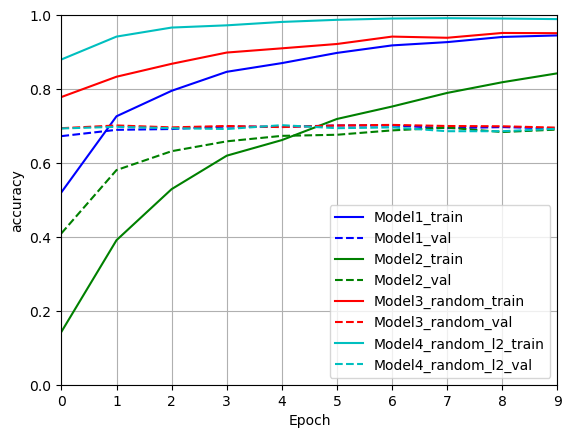

In [121]:
plot_accuracy(history_dict, metric='accuracy', ylim=[0.0, 1.0])

### Model Performance Overview with L2 Regularization

Based on the output from the random search with L2 regularization, here's how to interpret the results over 10 epochs:

1. **Loss Curves**:
   - **Training Loss**: Decreases from 1.1770 to 0.4879, showing that the model is effectively learning and improving its performance on the training set.
   - **Validation Loss**: Increases from 2.1555 to 2.5128, indicating potential overfitting. The gap between training and validation loss widens over time, suggesting that the model might be fitting too closely to the training data and not generalizing well.

2. **Accuracy Curves**:
   - **Action Task Labels Accuracy**:
     - **Training Accuracy**: Shows a strong improvement from 88.00% to 98.92%, reflecting effective learning on the training data.
     - **Validation Accuracy**: Remains relatively stable and lower, starting at 69.33% and ending at 69.26%. This indicates that despite improved training performance, the model's performance on the validation set does not see significant gains, suggesting overfitting.

   - **Person Task Labels Binary Accuracy**:
     - **Training Accuracy**: Increases from 78.44% to 93.21%, showing that the model is improving in predicting person labels.
     - **Validation Accuracy**: Shows fluctuation, starting at 69.78% and ending at 72.22%. This variability suggests inconsistent performance on the validation set.



### Conclusion

The application of L2 regularization has not substantially improved the validation performance. The persistent gap between training and validation metrics suggests the model is overfitting. Further experimentation with different regularization techniques or hyperparameters may be needed to enhance generalization and model robustness.


In [122]:
# Saving Random search with L2 Regularizer
best_model_l2.save('best_model_random_with_L2.h5')


### Comparing the Best Model L2 (Random Search with L2) with the Validation Dataset for accuracy

In [131]:
# Checking the best model from random search with L2
# Initialize lists to collect data
val_features_list = []
val_labels_action_list = []
val_labels_person_list = []

# Collect all data from validation_set
for features, labels in validation_set:
    val_features_list.append(features.numpy())
    val_labels_action_list.append(labels['action_task_labels'].numpy())
    val_labels_person_list.append(labels['person_task_labels'].numpy())

# Convert lists to numpy arrays
val_features = np.concatenate(val_features_list, axis=0)
val_labels_action = np.concatenate(val_labels_action_list, axis=0)
val_labels_person = np.concatenate(val_labels_person_list, axis=0)


In [132]:
val_action_labels

array(['feeding_a_horse', 'playing_guitar', 'walking_the_dog', ...,
       'brushing_teeth', 'gardening', 'holding_an_umbrella'], dtype=object)

In [133]:
# Predicting using the best model
predictions = best_model_l2.predict(val_features)

# Get the predicted labels for each task
predicted_action_labels = np.argmax(predictions['action_task_labels'], axis=1)
predicted_person_labels = np.argmax(predictions['person_task_labels'], axis=1)

# Get true labels for each task
true_action_labels = np.argmax(val_labels_action, axis=1)
true_person_labels = np.argmax(val_labels_person, axis=1)


43/43 [==============================] - 9s 182ms/step


In [135]:
from sklearn.metrics import classification_report

# Classification report for action task labels
print("Classification Report for Action Task Labels:")
print(classification_report(true_action_labels, predicted_action_labels, target_names=[f'Class {i}' for i in range(40)]))

# Classification report for person task labels
print("Classification Report for Person Task Labels:")
print(classification_report(true_person_labels, predicted_person_labels, target_names=['Person 0', 'Person 1']))

Classification Report for Action Task Labels:
              precision    recall  f1-score   support

     Class 0       0.54      0.49      0.51        73
     Class 1       0.80      0.92      0.85        38
     Class 2       0.86      0.91      0.88        46
     Class 3       0.70      0.62      0.66        45
     Class 4       0.87      0.94      0.90        49
     Class 5       0.94      0.92      0.93        49
     Class 6       0.57      0.76      0.65        41
     Class 7       0.91      0.91      0.91        43
     Class 8       0.78      0.83      0.80        52
     Class 9       0.82      0.78      0.79        40
    Class 10       0.60      0.43      0.50        35
    Class 11       0.46      0.52      0.49        23
    Class 12       0.94      0.89      0.91        36
    Class 13       0.84      0.90      0.87        30
    Class 14       0.45      0.39      0.42        36
    Class 15       0.73      0.61      0.67        44
    Class 16       0.81      0.86  

### Classification Report for Action Task Labels

- **Overall Accuracy:** The model achieved an overall accuracy of 69%, indicating that it correctly predicted the action task labels in 69% of the cases.


- **Overall Accuracy**: 69%

- **High-Performing Classes**:
  - **Class 5**: Precision 0.94, Recall 0.92, F1-score 0.93
  - **Class 4**: Precision 0.87, Recall 0.94, F1-score 0.90

- **Moderate-Performing Classes**:
  - **Class 2**: Precision 0.86, Recall 0.91, F1-score 0.88
  - **Class 7**: Precision 0.91, Recall 0.91, F1-score 0.91

- **Low-Performing Classes**:
  - **Class 38**: Precision 0.11, Recall 0.04, F1-score 0.06
  - **Class 23**: Precision 0.38, Recall 0.24, F1-score 0.29

- **Averages**:
  - **Macro Average**: Precision 0.66, Recall 0.68, F1-score 0.66
  - **Weighted Average**: Precision 0.68, Recall 0.69, F1-score 0.68

---

### Classification Report for Person Task Labels


- **Overall Accuracy:** The model achieved an overall accuracy of 72%, indicating that it correctly predicted the action task labels in 72% of the cases.

- **Overall Accuracy**: 72%

- **Performance**:
  - **Person 0**: Precision 0.78, Recall 0.80, F1-score 0.79
  - **Person 1**: Precision 0.62, Recall 0.59, F1-score 0.60

- **Averages**:
  - **Macro Average**: Precision 0.70, Recall 0.69, F1-score 0.69
  - **Weighted Average**: Precision 0.72, Recall 0.72, F1-score 0.72

### Conclusion
- **Action Task Labels:** The model shows varied performance across different classes, with some classes performing exceptionally well while others need improvement. The macro and weighted averages suggest a moderate overall performance.

- **Person Task Labels:** The model performs reasonably well, especially for Person 0. However, there is room for improvement in distinguishing Person 1. The overall performance is decent, with balanced metrics across the classes.
    


### Comparing the Best Model (Random Search without L2) with the Validation Dataset for accuracy


In [140]:
import numpy as np
from sklearn.metrics import classification_report

# Extract features and true labels from validation_set
val_features, val_labels = zip(*validation_set)

# Convert to numpy arrays
val_features = np.concatenate(val_features, axis=0)
val_labels = {key: np.concatenate([d[key] for d in val_labels], axis=0) for key in val_labels[0]}

# Checking shapes of tensors
print(f"Features shape: {val_features.shape}")
print(f"Labels shape: {[val_labels[key].shape for key in val_labels]}")

# Predict using the best model on CPU because GPU is OOM
with tf.device('/CPU:0'):
    predictions = best_model.predict(val_features)

# Get the predicted labels for each task
predicted_action_labels = np.argmax(predictions['action_task_labels'], axis=1)
predicted_person_labels = np.argmax(predictions['person_task_labels'], axis=1)

# Get true labels for each task
true_action_labels = np.argmax(val_labels['action_task_labels'], axis=1)
true_person_labels = np.argmax(val_labels['person_task_labels'], axis=1)

# Classification report for action task labels
print("Classification Report for Action Task Labels:")
print(classification_report(true_action_labels, predicted_action_labels, target_names=[f'Class {i}' for i in range(40)]))

# Classification report for person task labels
print("Classification Report for Person Task Labels:")
print(classification_report(true_person_labels, predicted_person_labels, target_names=['Person 0', 'Person 1']))


Features shape: (1350, 224, 224, 3)
Labels shape: [(1350, 40), (1350, 2)]
43/43 [==============================] - 51s 1s/step
Classification Report for Action Task Labels:
              precision    recall  f1-score   support

     Class 0       0.49      0.55      0.52        73
     Class 1       0.83      0.89      0.86        38
     Class 2       0.98      0.89      0.93        46
     Class 3       0.71      0.60      0.65        45
     Class 4       0.85      0.92      0.88        49
     Class 5       0.98      0.88      0.92        49
     Class 6       0.48      0.78      0.60        41
     Class 7       0.93      0.93      0.93        43
     Class 8       0.86      0.85      0.85        52
     Class 9       0.86      0.80      0.83        40
    Class 10       0.64      0.46      0.53        35
    Class 11       0.40      0.74      0.52        23
    Class 12       0.84      0.89      0.86        36
    Class 13       0.80      0.93      0.86        30
    Class 14    

### Comparing Best_Model(Random Search without L2)  Vs Best_Model_L2(Random Search with L2)

### Model Performance Comparison

#### **`best_model` vs. `best_model_l2`**

**Action Task Labels:**
- **`best_model`**
  - **Accuracy:** 70%
  - **Macro Average F1-Score:** 0.67
  - **Weighted Average F1-Score:** 0.69
- **`best_model_l2`**
  - **Accuracy:** 69%
  - **Macro Average F1-Score:** 0.66
  - **Weighted Average F1-Score:** 0.68

**Person Task Labels:**
- **`best_model`**
  - **Accuracy:** 74%
  - **Macro Average F1-Score:** 0.72
  - **Weighted Average F1-Score:** 0.74
- **`best_model_l2`**
  - **Accuracy:** 72%
  - **Macro Average F1-Score:** 0.69
  - **Weighted Average F1-Score:** 0.72

**Conclusion:**
- **`best_model`** which is the model without L2 demonstrates better performance in both action and person task labels, making it the superior model in this comparison.


## Predicting Labels for the Test Dataset

In [144]:
# Test dataset(future_predictions.csv) is already loaded in the variable(data_test)
data_test.head()

FileName
0  Img_1963.jpg
1  Img_7244.jpg
2  Img_6218.jpg
3  Img_7703.jpg
4  Img_6318.jpg

In [151]:
# Checking the shape if it has only one column

data_test.shape

# Making a copy of data_test to test_df
test_df = data_test.copy()

test_df.head()
print(test_df.shape)

(3128, 1)


In [152]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Define the path where images are stored
image_path = "Images"

def load_and_preprocess_image(img_filename):
    img_path = f"{image_path}/{img_filename}"
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Adjust target size if needed
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        return img_array
    except FileNotFoundError:
        print(f"File not found: {img_path}")
        return None

# Prepare test images
test_images = np.vstack([load_and_preprocess_image(img) for img in test_df['FileName'] if load_and_preprocess_image(img) is not None])

# Verify shapes
print(test_images.shape)


(3128, 224, 224, 3)


In [155]:

# Ensuring that TensorFlow uses the CPU for this block of code because of OOM
with tf.device('/CPU:0'):
    # Predict using the best model
    predictions = best_model.predict(test_images)

# Extract predicted labels
predicted_action_labels = np.argmax(predictions['action_task_labels'], axis=1)
predicted_person_labels = np.argmax(predictions['person_task_labels'], axis=1)





98/98 [==============================] - 129s 1s/step


In [167]:
print("Action Label Vocabulary:", action_tokenizer.get_vocabulary())


Action Label Vocabulary: ['applauding', 'riding_a_horse', 'holding_an_umbrella', 'cooking', 'climbing', 'playing_guitar', 'jumping', 'riding_a_bike', 'walking_the_dog', 'feeding_a_horse', 'drinking', 'reading', 'playing_violin', 'fixing_a_car', 'phoning', 'blowing_bubbles', 'fishing', 'running', 'writing_on_a_book', 'pushing_a_cart', 'smoking', 'using_a_computer', 'fixing_a_bike', 'waving_hands', 'pouring_liquid', 'watching_TV', 'looking_through_a_telescope', 'cleaning_the_floor', 'shooting_an_arrow', 'gardening', 'throwing_frisby', 'taking_photos', 'cutting_trees', 'brushing_teeth', 'writing_on_a_board', 'rowing_a_boat', 'looking_through_a_microscope', 'cutting_vegetables', 'texting_message', 'washing_dishes']


In [168]:
# Get the vocabulary (i.e., the original string labels) for both action and person labels
action_vocab = action_tokenizer.get_vocabulary()  # List of original action labels
person_vocab = person_tokenizer.get_vocabulary()  # List of original person labels

# Convert numeric predictions to string labels
predicted_action_labels = [action_vocab[label] for label in np.argmax(predictions['action_task_labels'], axis=1)]
predicted_person_labels = [person_vocab[label] for label in np.argmax(predictions['person_task_labels'], axis=1)]


# Display or save predictions
test_df['Class'] = predicted_action_labels
test_df['MoreThanOnePerson'] = predicted_person_labels

In [169]:
# Saving the results to s3967377_predictions.csv file
test_df.to_csv('s3967377_predictions.csv', index=False)


In [157]:

# Retrieve the best hyperparameters for l2 with random search model
#best_hyperparameters = tuner.get_best_hyperparameters(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display best hyperparameters
print("Best Hyperparameters:")
for hp_name in best_hyperparameters.values.keys():
    print(f"{hp_name}: {best_hyperparameters.values[hp_name]}")


Best Hyperparameters:
l2_reg: 0.0001
lr: 0.0001


### Ethical Issues and Biases in the Stanford Dataset

1. **Data Privacy and Security**  
   The dataset includes images of people performing various actions, raising privacy concerns. Even if anonymized, there’s a risk of identifying individuals. To address this:
   - Ensure proper anonymization.
   - Restrict access to authorized personnel.
   - Comply with regulations like GDPR.
   - Obtain consent where possible.

2. **Bias in Labeling**  
   Labels for actions and individuals could be biased if not consistently applied. To reduce bias:
   - Use objective labeling criteria.
   - Train labelers thoroughly.
   - Employ multiple reviewers for consistent labeling.

3. **Representation Bias**  
   The dataset may not equally represent all demographic groups. If certain age groups, genders, or ethnicities are underrepresented, the model may not perform well across populations. To address this:
   - Ensure diverse representation in the dataset.
   - Regularly test the model’s fairness and adjust accordingly.

4. **Potential for Misuse**  
   Action recognition models could be misused in privacy-violating surveillance or applications reinforcing stereotypes. To prevent misuse:
   - Establish ethical guidelines.
   - Ensure the technology is used positively and responsibly.

5. **Bias from Dataset Distribution**  
   The dataset is imbalanced, with some actions (e.g., applauding) more frequent than others (e.g., washing dishes). This imbalance may bias the model toward frequent actions. Additionally, there are more single-person images (2830) than multiple-person ones (1670), which could affect performance. To address this:
   - Use data augmentation or resampling techniques.
   - Ensure the model can handle less frequent actions and scenarios effectively.
